# Imports

In [183]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
3
NVIDIA GeForce RTX 3090


In [184]:
from orbit_generation.constants import EM_MU
from orbit_generation.data import TSFeatureWiseScaler, create_dataloaders
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits, export_dynamic_orbits_html
from orbit_generation.stats import plot_histograms_comparison
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.model_factory import get_model
from orbit_generation.architectures import VAELossHistory
from orbit_generation.propagation import jacobi_constant, calculate_errors_per_orbit
from orbit_generation.experiment import setup_new_experiment, add_experiment_metrics
from orbit_generation.evaluation import evaluate_clustering_multiple_labels, calculate_closest_feature_distances, find_nearest_orbits_batch, calculate_pairwise_distances
from orbit_generation.latent_space import plot_2d_latent_space, plot_combined_2d_latent_space, reduce_dimensions_latent_space, compute_centroids, interpolate_sample
from orbit_generation.convergence import process_diferential_correction_orbits

In [185]:
import numpy as np
import pandas as pd
import os
from pytorch_lightning import Trainer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Parameters

In [186]:
want_to_train = False   # Set this parameter to False if you want to load the model from the folder
want_to_generate = True    # Set this parameter to False if you want to load the generation from the folder
calculate_error_metrics = True   # Set this parameter to False if you don't want to calculate any metric
want_to_get_cluster_metrics = True    # Set this parameter to False if you don't want to calculate clustering metrics
want_to_perform_convergence = True   # Set this parameter to False if you don't want to perform convergence

In [187]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "../experiments"

In [188]:
params = {
    'model_name': 'vae_conv5_legit',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 2,
    'feature_dim': 7,
    'seq_len': 100,
    'val_split': 0.05,
    'batch_size': 32,
    'epochs': 25,
    'beta': 0.1,
    'lr': 0.001,
    'dropout_rate': 0.2,
    'samples_to_generate' : 100,
    'distance_metric' : 'euclidean',
    'max_iter_convergence' : 50
}

# Saving paths

In [189]:
# Experiment
experiment_folder = setup_new_experiment(params, experiments_folder)
images_folder = os.path.join(experiment_folder, 'images')
if not os.path.exists(images_folder):
    os.makedirs(images_folder)
experiment_id = os.path.basename(experiment_folder).split('_')[1]

Parameters already exist for experiment: ../experiments/experiment_13


In [190]:
# Images
static_all_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_all_generated_orbits.png')
static_some_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_some_generated_orbits.png')
dynamic_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.html')
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
converged_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_converged_orbits')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
dynamical_refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')
model_losses_path = os.path.join(images_folder, f'exp{experiment_id}_model_losses.png')
histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_histogram_comparison.png')
generated_orbits_that_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_converged.png')
generated_orbits_that_did_not_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_not_converged.png')
refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.png')
family_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_family_centroids')

# Model
model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model.pth')

# Orbits
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_orbits.npy')
refined_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits.npy')

# Latent Representations
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
family_centroids_path = os.path.join(images_folder, f'exp{experiment_id}_family_centroids.npy')

# Features
generation_df_path = os.path.join(experiment_folder, f'exp{experiment_id}_generation_df.csv')
refined_orbits_df_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits_df.csv')


# Data

## Import

In [191]:
data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

(45211, 7, 100)

Remove the time variable if specified in params

In [192]:
if params['feature_dim']==6:
    data=data[:,1:,:]
    data.shape

## Scaling

In [193]:
scaler = TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(torch.tensor(data, dtype=torch.float32))
scaled_data.shape

torch.Size([45211, 7, 100])

# Modelling

In [194]:
model = get_model(params)

In [195]:
if want_to_train:
    train_loader, val_loader = create_dataloaders(scaled_data, val_split=params.get('val_split', 0.1), batch_size=params.get('batch_size', 32))

    loss_history = VAELossHistory()

    trainer = Trainer(
        max_epochs=params.get('epochs', 10),
        log_every_n_steps=10,
        devices="auto",
        accelerator="auto",
        enable_progress_bar=True,
        enable_model_summary=True,
        callbacks=[loss_history]
    )

    trainer.fit(model, train_loader, val_loader)

    for metric_name, metric_value in trainer.callback_metrics.items():
        print(f"{metric_name}: {metric_value}")

In [196]:
if want_to_train:
    add_experiment_metrics(experiments_folder, params=params, metrics=trainer.callback_metrics)
    torch.save(model.state_dict(), model_save_path)
    loss_history.plot_all_losses(save_path=model_losses_path)
else:
    model.load_state_dict(torch.load(model_save_path, weights_only=True))  

## Generate

In [197]:
if want_to_generate:
    # Generate the orbits
    generation = model.sample(params['samples_to_generate'])
    generation = scaler.inverse_transform(generation)
    np.save(generated_data_path, generation.detach().numpy())
else:
    # Load the orbits
    generation = np.load(generated_data_path)

generation.shape

torch.Size([100, 7, 100])

# Analysis of Generation

## Visualization

In [198]:
if torch.is_tensor(generation):
    generation=generation.detach().numpy()

if generation.shape[1] == 7:
    no_time_generation = generation[:,1:,:]
    generation.shape
else:
    no_time_generation = generation

no_time_generation.shape

(100, 6, 100)

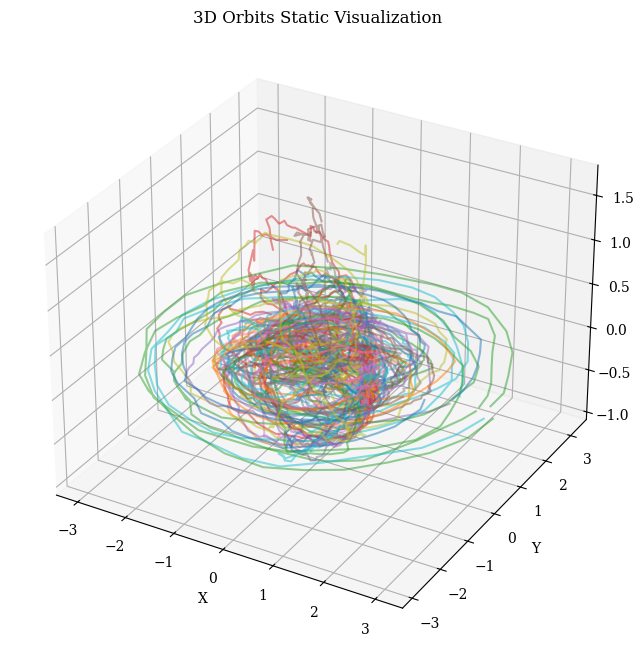

In [199]:
visualize_static_orbits(data= no_time_generation, show_legend=False, save_path=static_all_orbit_path)

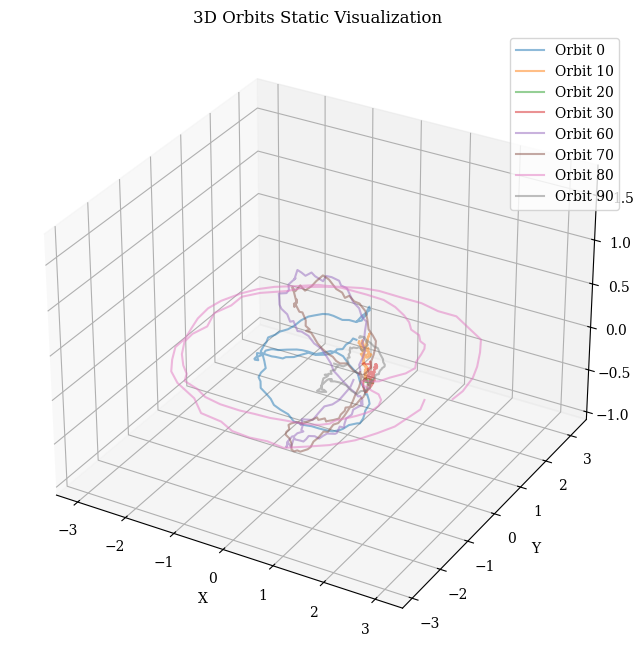

In [200]:
visualize_static_orbits(data= no_time_generation, orbit_indices=[0,10,20,30,60,70,80,90], save_path=static_some_orbit_path)

In [201]:
export_dynamic_orbits_html(data=no_time_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment_13/images/exp13_generated_orbits.html


## Coverage

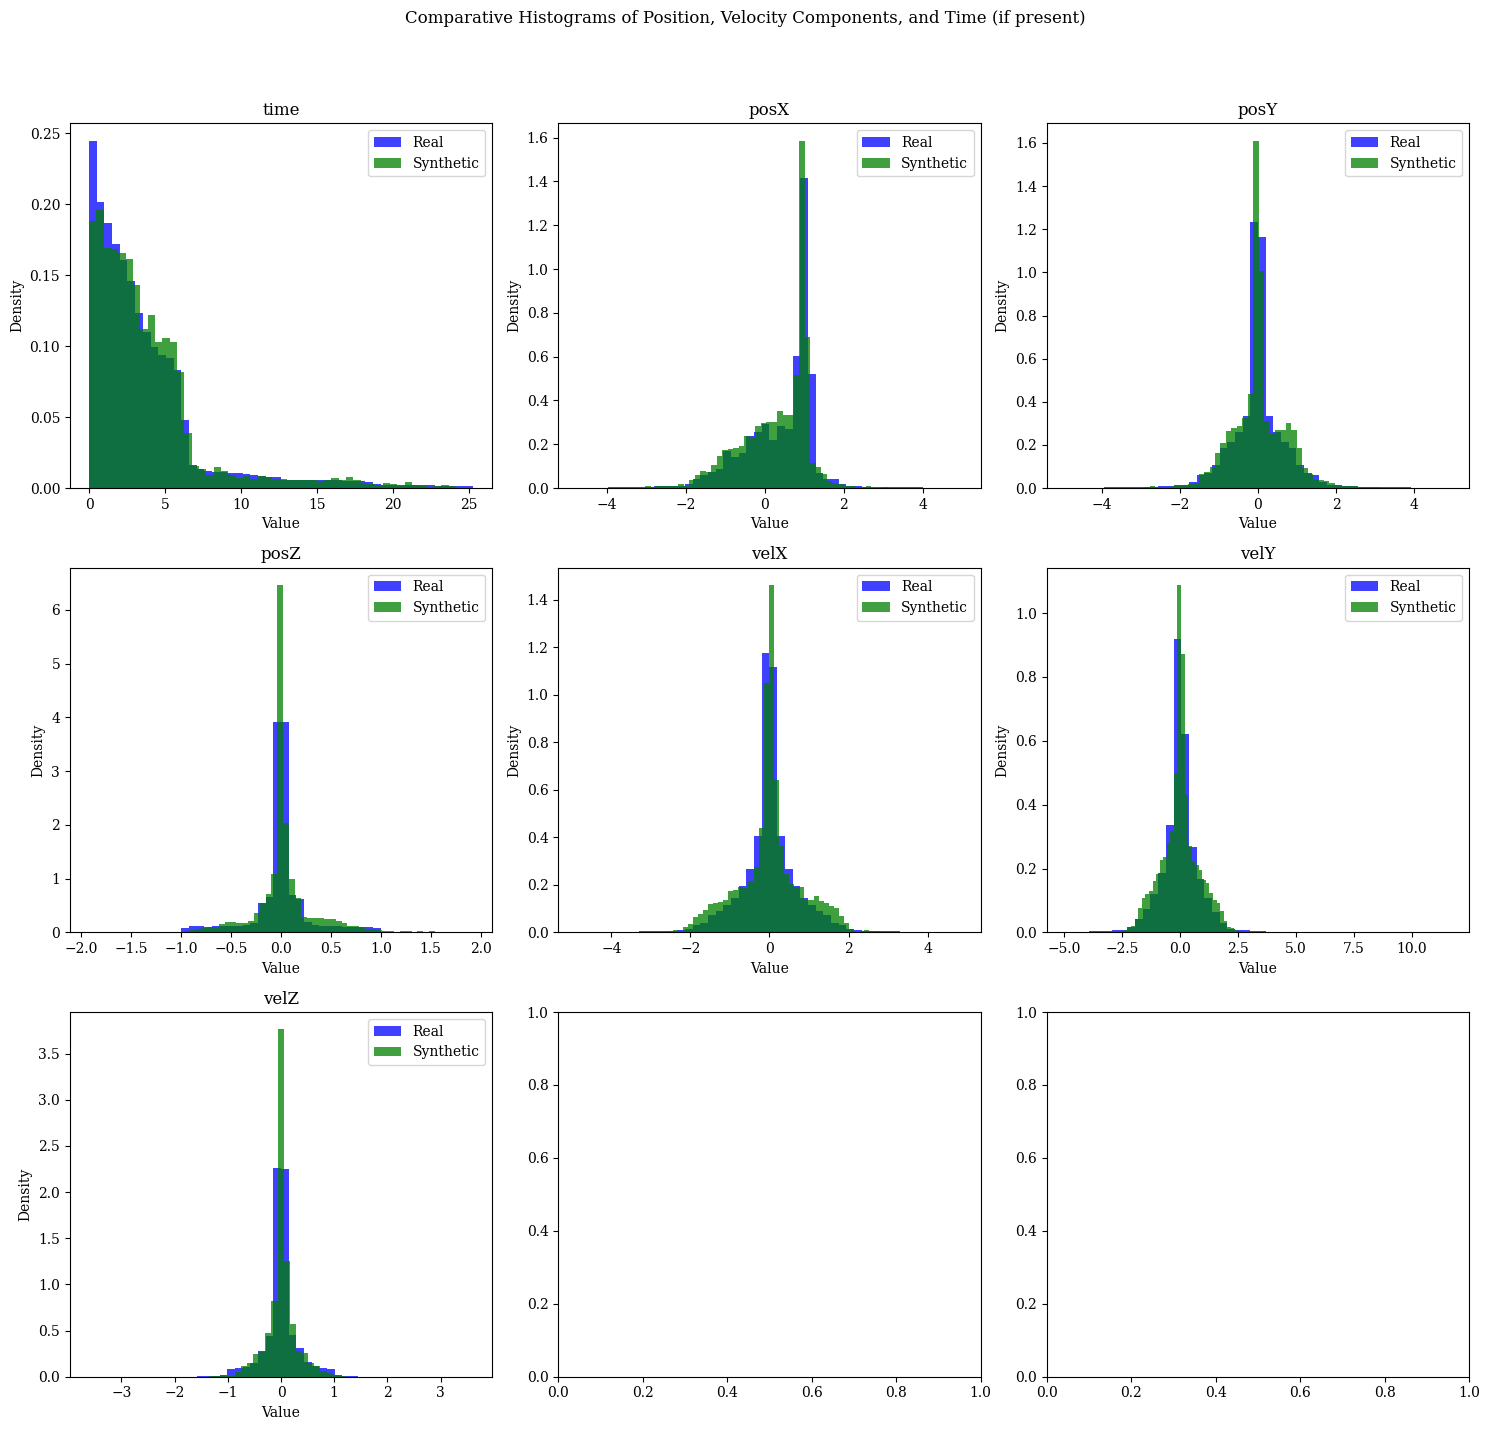

In [202]:
plot_histograms_comparison(data1=data, data2=generation, label1='Real', label2='Synthetic', normalize=True, save_path=histogram_comparison_path)

## Pheasibility

In [203]:
if calculate_error_metrics:
    reordered_generation, order_metrics = reorder_orbits(generation)
    per_orbit_errors = calculate_errors_per_orbit(reordered_generation,EM_MU)
    mean_errors = {key: np.mean(value) for key, value in per_orbit_errors.items()}
    add_experiment_metrics(experiments_folder, params=params, metrics={**mean_errors, **order_metrics})

Metrics added to experiment with ID 13 in ../experiments/experiments.json.


# Latent Space

In [204]:
latent_means, latent_log_vars = model.encode(scaled_data)
latent_means = latent_means.detach().numpy()
latent_log_vars = latent_log_vars.detach().numpy()
latent_representation = np.concatenate((latent_means, latent_log_vars), axis=1)
np.save(latent_representations_path, latent_representation)
latent_representation.shape

(45211, 4)

In [205]:
orbits_id_classes = [orbit_df.at[index, 'id_class'] for index in labels]
family_labels=get_orbit_classes(orbits_id_classes)[0]

feature_names=['jacobi', 'period', 'stability']
features=orbit_df[feature_names].to_numpy()

In [206]:
# Compute centroids
centroid_means = compute_centroids(latent_means, orbits_id_classes, method='mean')
centroid_log_vars = compute_centroids(latent_log_vars, orbits_id_classes, method='mean')
centroids_representation = np.concatenate((centroid_means, centroid_log_vars), axis=1)
np.save(family_centroids_path, centroids_representation)
centroids_representation.shape

(40, 4)

In [207]:
unique_classes = list(set(orbits_id_classes))
family_names=get_orbit_classes(unique_classes)[0]
len(family_names)

40

## Visualize

Dataset

Saved plot to ../experiments/experiment_13/images/exp13_latent_space


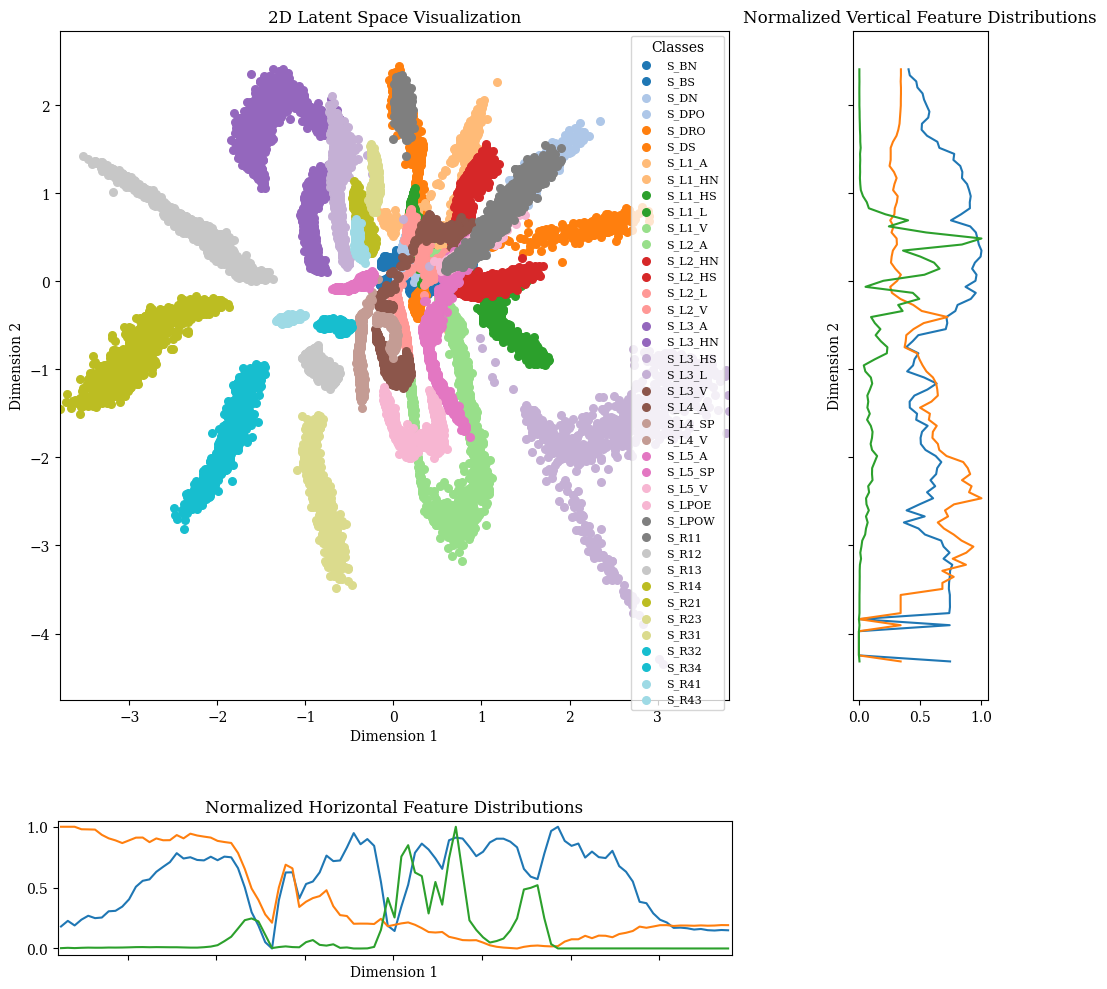

In [208]:
if latent_means.shape[1]==2:
    plot_2d_latent_space(latent_means,
                            np.array(family_labels),
                            save_path=latent_space_path,
                            features=features,
                            feature_names=feature_names)
else:
    rls=reduce_dimensions_latent_space(latent_means,
                                        np.array(family_labels),
                                        techniques=['PCA','UMAP','t-SNE'],
                                        save_path=latent_space_path,
                                        show_legend=False)

Centroids

Saved plot to ../experiments/experiment_13/images/exp13_family_centroids


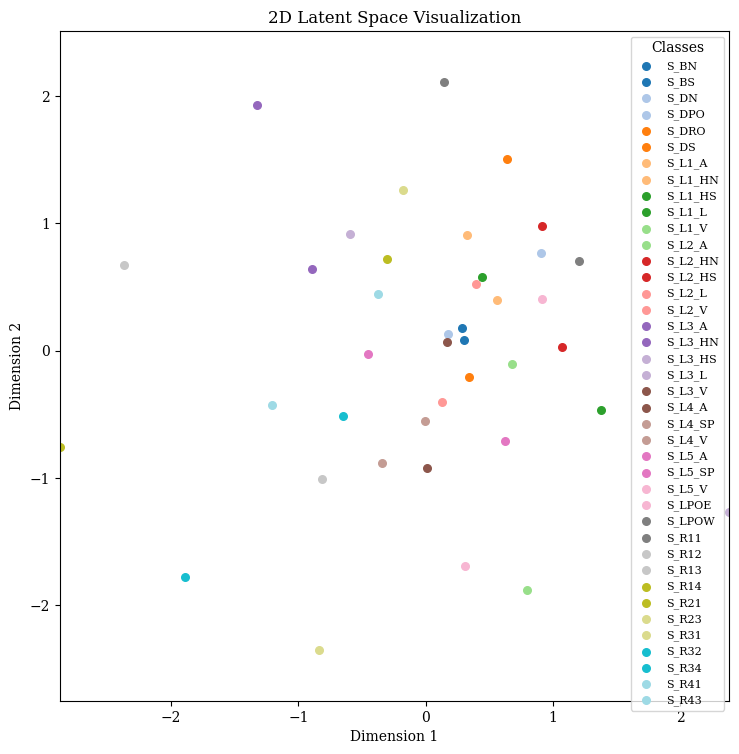

In [209]:
if latent_means.shape[1]==2:
    plot_2d_latent_space(centroid_means,
                            np.array(family_names),
                            save_path=family_centroids_plot_path)
else:
    rls=reduce_dimensions_latent_space(centroid_means,
                                        np.array(family_names),
                                        techniques=['PCA','UMAP','t-SNE'],
                                        save_path=family_centroids_plot_path,
                                        show_legend=False)

## Clustering

In [210]:
if want_to_get_cluster_metrics:
    cluster_metrics = evaluate_clustering_multiple_labels(latent_means, [family_labels], label_names=['family'], clustering_method='gmm')
    add_experiment_metrics(experiments_folder, params=params, metrics=cluster_metrics)

Metrics added to experiment with ID 13 in ../experiments/experiments.json.


# Convergence

In [211]:
if want_to_perform_convergence:
    refined_orbits, refined_orbits_df= process_diferential_correction_orbits(np.transpose(reordered_generation,(0,2,1)),
                                                                        EM_MU,
                                                                        max_iter=params['max_iter_convergence'])
    refined_orbits = np.transpose(refined_orbits,(0,2,1))
    np.save(refined_data_path, refined_orbits)
else:
    refined_orbits = np.load(refined_data_path)

refined_orbits.shape

INFO:orbit_generation.convergence:Processing orbit 1/100
INFO:orbit_generation.convergence:Orbit 0: Success=1, Norm=4.595437783644743e-10, Iterations=8
INFO:orbit_generation.convergence:Processing orbit 2/100
INFO:orbit_generation.convergence:Orbit 1: Success=-1, Norm=13.867338555714156, Iterations=3
INFO:orbit_generation.convergence:Processing orbit 3/100
INFO:orbit_generation.convergence:Orbit 2: Success=-1, Norm=14.118585168159221, Iterations=3
INFO:orbit_generation.convergence:Processing orbit 4/100
INFO:orbit_generation.convergence:Orbit 3: Success=1, Norm=6.960248966083652e-12, Iterations=10
INFO:orbit_generation.convergence:Processing orbit 5/100
INFO:orbit_generation.convergence:Orbit 4: Success=-1, Norm=10.996816846808947, Iterations=4
INFO:orbit_generation.convergence:Processing orbit 6/100
INFO:orbit_generation.convergence:Orbit 5: Success=-1, Norm=3.6763701847650956e-15, Iterations=50
INFO:orbit_generation.convergence:Processing orbit 7/100
INFO:orbit_generation.convergence

(44, 7, 100)

Test Convergence

In [212]:
# reordered_generation_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_reordered_generation.npy')
# np.save(reordered_generation_data_path, reordered_generation)
# reordered_generation.shape

In [213]:
reordered_refined_orbits, refined_order_metrics = reorder_orbits(refined_orbits)
refined_order_metrics

{'average_disorder_metric': np.float64(170.22727272727272),
 'percentage_correct_order': np.float64(73.92102846648301),
 'average_inversions': 111.47727272727273,
 'average_kendall_tau': np.float64(0.04504132231404944)}

In [214]:
refined_per_orbit_errors = calculate_errors_per_orbit(reordered_refined_orbits,EM_MU)
refined_orbits_df['propagated_position_error'] = refined_per_orbit_errors['position_error']
refined_orbits_df['propagated_velocity_error'] = refined_per_orbit_errors['velocity_error']
refined_orbits_df['propagated_energy_error'] = refined_per_orbit_errors['energy_error']
refined_mean_errors = {key: np.mean(value) for key, value in refined_per_orbit_errors.items()}
refined_mean_errors

{'position_error': np.float64(2.545491523341524e-12),
 'velocity_error': np.float64(6.352411428066559e-12),
 'energy_error': np.float64(2.587187718423167e-11)}

In [215]:
generation_df = pd.DataFrame(per_orbit_errors)
generation_df.head()

,position_error,velocity_error,energy_error
0,0.349104,0.660819,1.641020
1,0.311150,0.640721,0.948592
2,0.311380,0.350754,0.365107
3,0.344559,0.607427,0.505330
4,0.045707,0.239480,0.323018


In [216]:
refined_orbits_df.head()

,id,old_period,new_period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,propagated_position_error,propagated_velocity_error,propagated_energy_error
0,0,6.384332,6.332033,8,4.595438e-10,0.668319,-0.091928,0.418383,-0.030522,-1.420890,-0.002433,0.855572,-0.144324,5.038043e-01,-0.285265,-1.843407,-4.044137e-02,5.224472e-12,2.220178e-11,2.906602e-10
1,3,6.777366,6.297332,10,6.960249e-12,0.638434,-0.457626,0.557154,-0.979981,-1.330561,-0.114005,0.638527,-0.473563,6.023921e-01,-0.942112,-1.502993,-1.747267e-01,8.533816e-13,3.487078e-12,1.411706e-12
2,7,6.221169,6.073369,8,2.455596e-12,0.482920,0.427402,-0.006965,-0.117632,0.785919,0.021754,0.431119,0.222623,1.414803e-13,-0.187502,1.254837,3.587083e-13,1.744863e-12,3.735182e-12,1.489628e-13
3,9,11.816135,12.508454,19,1.843497e-11,1.026570,0.143554,-0.010648,0.451653,0.287824,0.008607,0.664786,1.491920,1.673391e-02,0.799931,-0.310704,1.227272e-02,6.577496e-12,8.190169e-12,6.253853e-13
4,12,6.756017,6.094421,9,4.766615e-11,0.453887,-0.010911,0.023229,-0.194785,1.556372,0.004290,0.434944,-0.011655,-1.162722e-13,0.013311,1.420659,4.338131e-13,1.803447e-12,3.937356e-12,9.085536e-12


In [217]:
refined_ids = refined_orbits_df['id'].astype(int).tolist()
generated_data_that_was_refined = generation[refined_ids]
generated_data_that_was_refined.shape

(44, 7, 100)

Generation that was able to get Refined

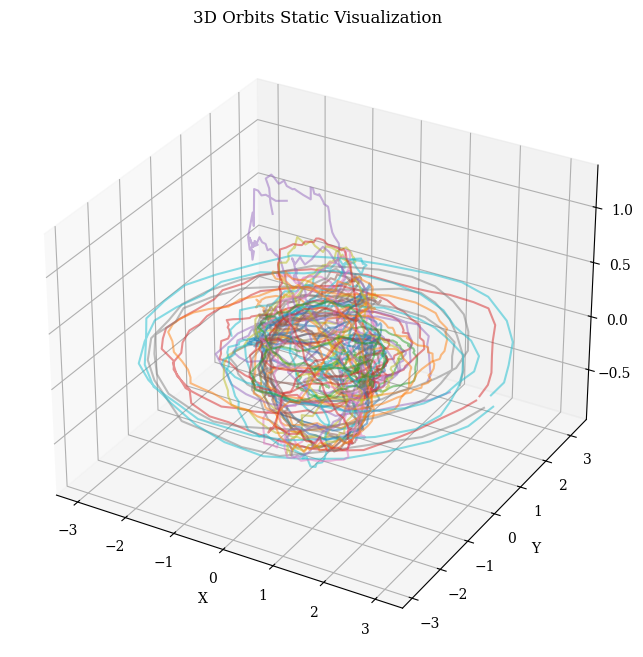

In [218]:
visualize_static_orbits(generated_data_that_was_refined[:,1:,:], show_legend=False, save_path=generated_orbits_that_converged_path)

Refinement

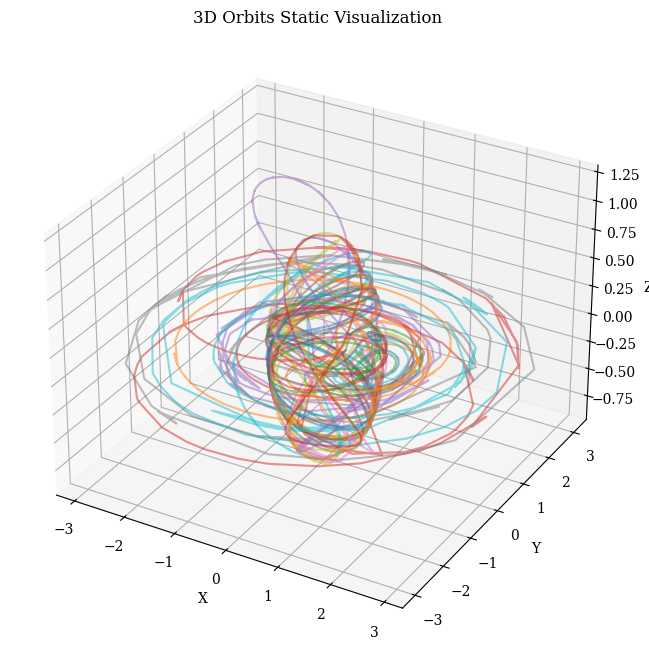

In [219]:
visualize_static_orbits(refined_orbits[:,1:,:], show_legend=False, save_path=refined_orbits_path)

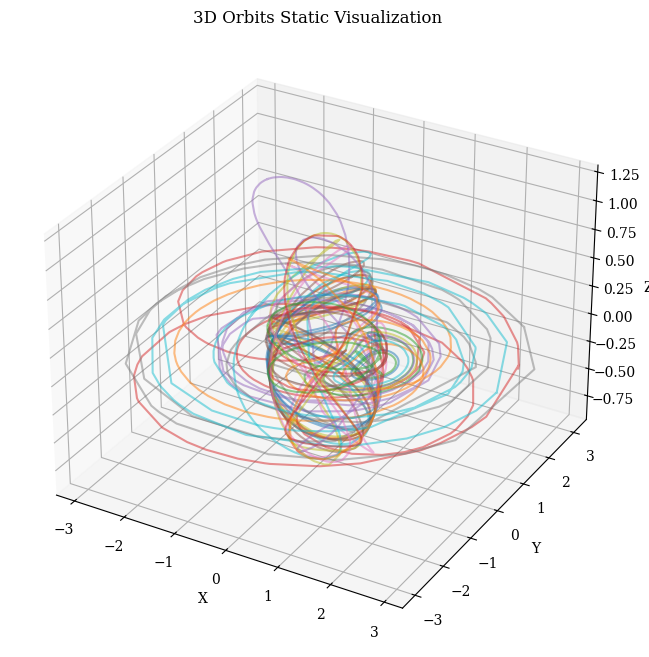

In [220]:
visualize_static_orbits(reordered_refined_orbits[:,1:,:], show_legend=False, save_path=refined_orbits_path)

Generation that didn't manage to get refined

In [221]:
non_refined_ids = sorted(set(range(params['samples_to_generate'])) - set(refined_ids))
generated_data_that_was_not_refined = generation[non_refined_ids]
generated_data_that_was_not_refined.shape

(56, 7, 100)

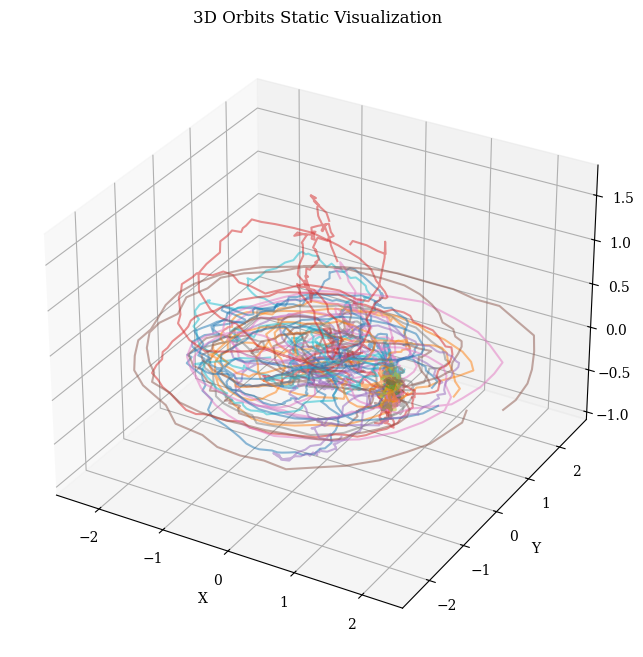

In [222]:
visualize_static_orbits(generated_data_that_was_not_refined[:,1:,:], show_legend=False, save_path=generated_orbits_that_did_not_converged_path)

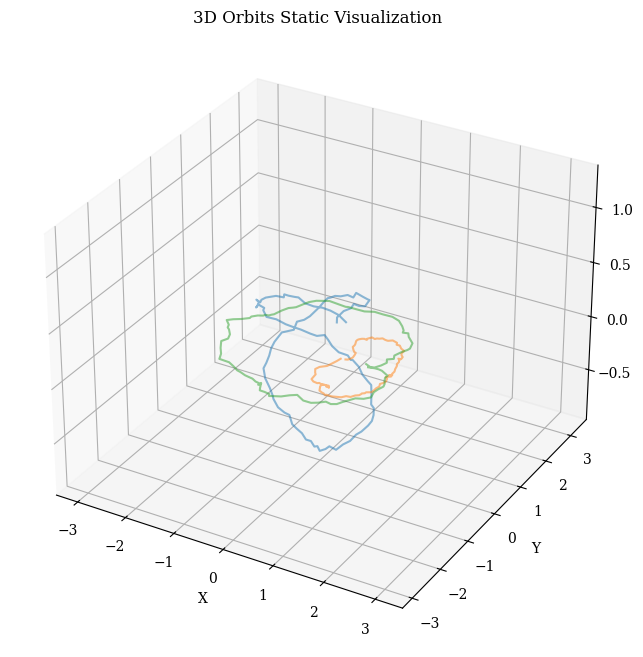

In [223]:
visualize_static_orbits(generated_data_that_was_refined[:,1:,:], show_legend=False, save_path=generated_orbits_that_converged_path, orbit_indices=[1,2,3])

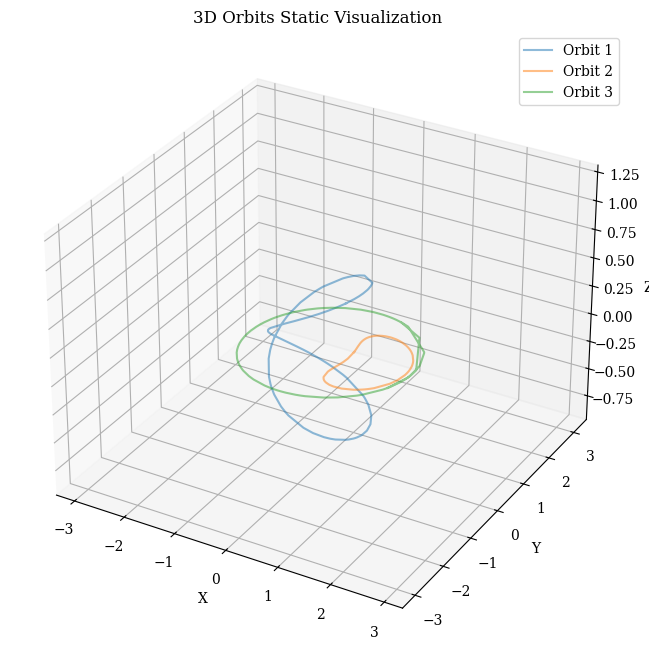

In [243]:
visualize_static_orbits(reordered_refined_orbits[:,1:,:], show_legend=True, save_path=refined_orbits_path, orbit_indices=[1,2,3])

## Latent Space

In [225]:
refined_scaled_data = scaler.transform(torch.from_numpy(refined_orbits).float())
refined_latent_means, refined_latent_log_vars = model.encode(refined_scaled_data)
refined_latent_representations = refined_latent_means.detach().numpy()
refined_latent_representations.shape

(44, 2)

Saved plot to ../experiments/experiment_13/images/exp13_combined_latent_space


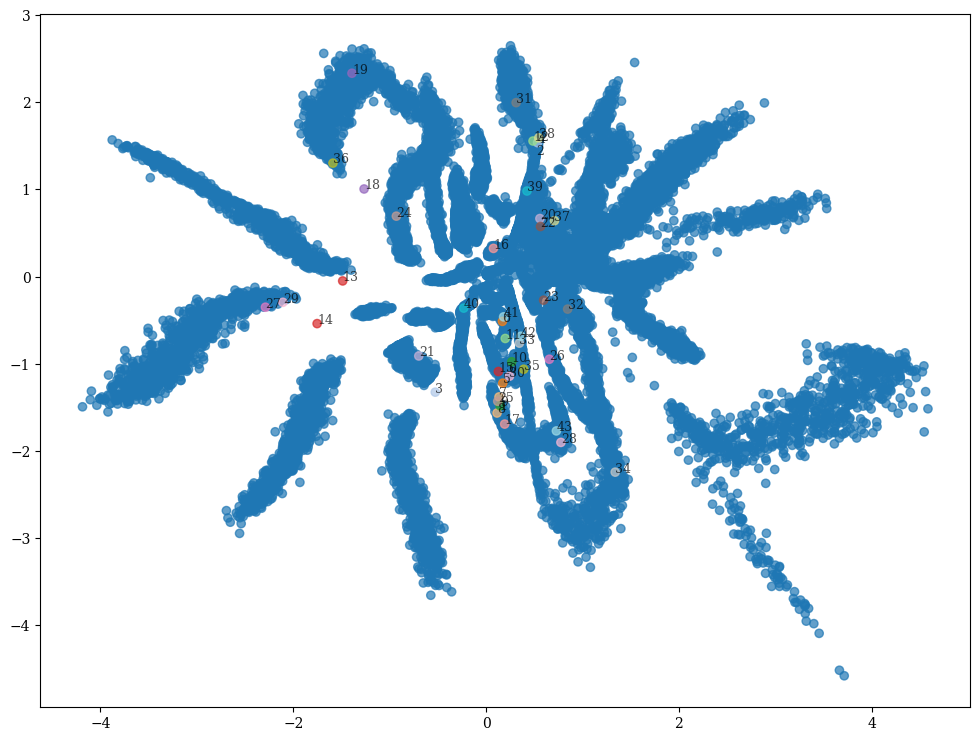

In [226]:
if refined_latent_representations.shape[1]>2:
    rls=reduce_dimensions_latent_space(train_latent=latent_representation,
                                        val_latent=refined_latent_representations)
    latent_representation=rls['PCA']['train']
    refined_latent_representations=rls['PCA']['val']

plot_combined_2d_latent_space(
    real_latent=latent_means, 
    synthetic_latent=refined_latent_representations,
    synthetic_labels=list(range(0, len(refined_scaled_data))),
    annotation_mode='numbers',
    save_path=combined_latent_space_path
)

In [227]:
### plot how far away we are from each convergence and generation in the latent space

## Check Novelty

Calculate Jacobi Constant on the dataset

In [228]:
results = np.array([jacobi_constant(np.transpose(data[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(data.shape[0])])
orbit_df['calculated_jacobi'] = results

orbit_df.head()

,id_class,x_0,y_0,x_0,vx_0,vy_0,vz_0,jacobi,period,stability,propagated_periods,calculated_jacobi
0,1.0,0.941000,1.900442e-23,0.509474,2.968938e-13,-0.124968,-3.122717e-12,2.745412,11.555291,211.184678,3.0,2.757415
1,1.0,0.941538,-8.592698e-24,0.508602,2.902340e-13,-0.125672,-3.252212e-12,2.746226,11.551622,210.329145,3.0,2.758229
2,1.0,0.942076,6.956604e-24,0.507729,2.685527e-13,-0.126375,-2.862050e-12,2.747039,11.547936,209.473685,3.0,2.759042
3,1.0,0.942613,1.763946e-24,0.506856,3.153637e-13,-0.127078,-3.791054e-12,2.747850,11.544233,208.618315,3.0,2.759853
4,1.0,0.943150,9.441804e-24,0.505982,2.663322e-13,-0.127781,-2.982720e-12,2.748660,11.540511,207.763051,3.0,2.760663


Calculate Jacobi Constant and Period on the Refined Orbits

In [229]:
new_jacobis = np.array([jacobi_constant(np.transpose(refined_orbits[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(refined_orbits.shape[0])])
refined_orbits_df['calculated_jacobi'] = new_jacobis
refined_orbits_df.rename(columns={'new_period': 'period'}, inplace=True)
refined_orbits_df['period_distance_with_generation'] = abs(refined_orbits_df['period'] - refined_orbits_df['old_period'])
refined_orbits_df.head()

,id,old_period,period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,propagated_position_error,propagated_velocity_error,propagated_energy_error,calculated_jacobi,period_distance_with_generation
0,0,6.384332,6.332033,8,4.595438e-10,0.668319,-0.091928,0.418383,-0.030522,-1.420890,-0.002433,0.855572,-0.144324,5.038043e-01,-0.285265,-1.843407,-4.044137e-02,5.224472e-12,2.220178e-11,2.906602e-10,-0.722369,0.052299
1,3,6.777366,6.297332,10,6.960249e-12,0.638434,-0.457626,0.557154,-0.979981,-1.330561,-0.114005,0.638527,-0.473563,6.023921e-01,-0.942112,-1.502993,-1.747267e-01,8.533816e-13,3.487078e-12,1.411706e-12,-0.538865,0.480034
2,7,6.221169,6.073369,8,2.455596e-12,0.482920,0.427402,-0.006965,-0.117632,0.785919,0.021754,0.431119,0.222623,1.414803e-13,-0.187502,1.254837,3.587083e-13,1.744863e-12,3.735182e-12,1.489628e-13,2.661183,0.147799
3,9,11.816135,12.508454,19,1.843497e-11,1.026570,0.143554,-0.010648,0.451653,0.287824,0.008607,0.664786,1.491920,1.673391e-02,0.799931,-0.310704,1.227272e-02,6.577496e-12,8.190169e-12,6.253853e-13,3.164983,0.692318
4,12,6.756017,6.094421,9,4.766615e-11,0.453887,-0.010911,0.023229,-0.194785,1.556372,0.004290,0.434944,-0.011655,-1.162722e-13,0.013311,1.420659,4.338131e-13,1.803447e-12,3.937356e-12,9.085536e-12,2.644280,0.661597


Compare Features between Dataset and Refinement

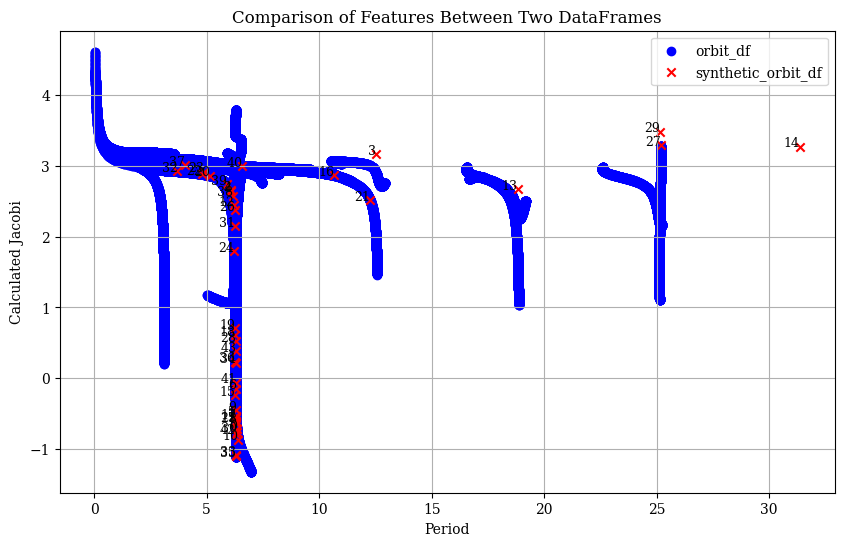

In [230]:
features = ['period', 'calculated_jacobi']

feature_distances = calculate_closest_feature_distances(orbit_df, refined_orbits_df, features)
refined_orbits_df['feature_distance_from_closest'] = feature_distances

## Calculate distances

In [231]:
if data.shape[1] == 7:
    no_time_data = data[:,1:,:]
    no_time_refined_orbits = refined_orbits[:,1:,:]
    no_time_generated_data_that_was_refined = generated_data_that_was_refined[:,1:,:]
else:
    no_time_data = data
    no_time_refined_orbits = refined_orbits
    no_time_generated_data_that_was_refined = generated_data_that_was_refined

print(no_time_data.shape)
print(no_time_refined_orbits.shape)
print(no_time_generated_data_that_was_refined.shape)
print(no_time_generation.shape)


(45211, 6, 100)
(44, 6, 100)
(44, 6, 100)
(100, 6, 100)


In [232]:
no_time_generation.shape

(100, 6, 100)

In [233]:
no_time_data.shape

(45211, 6, 100)

In [234]:
nearest_indices_generation, nearest_distances_generation = find_nearest_orbits_batch(no_time_generation,
                                                                                     no_time_data,
                                                                                     n=1,
                                                                                     distance_metric=params['distance_metric'])
generation_df['nearest_orbit'] = nearest_indices_generation
generation_df['nearest_orbit_distance'] = nearest_distances_generation
generation_df.head()

,position_error,velocity_error,energy_error,nearest_orbit,nearest_orbit_distance
0,0.349104,0.660819,1.641020,0,24.697138
1,0.311150,0.640721,0.948592,0,24.211694
2,0.311380,0.350754,0.365107,0,19.581664
3,0.344559,0.607427,0.505330,0,23.488796
4,0.045707,0.239480,0.323018,0,6.304963


In [235]:
nearest_indices_refined_generation, nearest_distances_refined_generation = find_nearest_orbits_batch(no_time_refined_orbits,
                                                                                                     no_time_data,
                                                                                                     n=1,
                                                                                                     distance_metric=params['distance_metric'])
refined_orbits_df['nearest_orbit'] = nearest_indices_refined_generation
refined_orbits_df['nearest_orbit_distance'] = nearest_distances_refined_generation

In [236]:
pairwise_distances = calculate_pairwise_distances(no_time_generated_data_that_was_refined,
                                                  no_time_refined_orbits,
                                                  distance_metric=params['distance_metric'])
refined_orbits_df['distance_from_generation'] = pairwise_distances
refined_orbits_df.head()

,id,old_period,period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,propagated_position_error,propagated_velocity_error,propagated_energy_error,calculated_jacobi,period_distance_with_generation,feature_distance_from_closest,nearest_orbit,nearest_orbit_distance,distance_from_generation
0,0,6.384332,6.332033,8,4.595438e-10,0.668319,-0.091928,0.418383,-0.030522,-1.420890,-0.002433,0.855572,-0.144324,5.038043e-01,-0.285265,-1.843407,-4.044137e-02,5.224472e-12,2.220178e-11,2.906602e-10,-0.722369,0.052299,0.000437,0,24.069816,8.561540
1,3,6.777366,6.297332,10,6.960249e-12,0.638434,-0.457626,0.557154,-0.979981,-1.330561,-0.114005,0.638527,-0.473563,6.023921e-01,-0.942112,-1.502993,-1.747267e-01,8.533816e-13,3.487078e-12,1.411706e-12,-0.538865,0.480034,0.000275,0,23.978757,8.069549
2,7,6.221169,6.073369,8,2.455596e-12,0.482920,0.427402,-0.006965,-0.117632,0.785919,0.021754,0.431119,0.222623,1.414803e-13,-0.187502,1.254837,3.587083e-13,1.744863e-12,3.735182e-12,1.489628e-13,2.661183,0.147799,0.000926,0,12.783159,3.274189
3,9,11.816135,12.508454,19,1.843497e-11,1.026570,0.143554,-0.010648,0.451653,0.287824,0.008607,0.664786,1.491920,1.673391e-02,0.799931,-0.310704,1.227272e-02,6.577496e-12,8.190169e-12,6.253853e-13,3.164983,0.692318,0.219894,0,21.579031,7.332367
4,12,6.756017,6.094421,9,4.766615e-11,0.453887,-0.010911,0.023229,-0.194785,1.556372,0.004290,0.434944,-0.011655,-1.162722e-13,0.013311,1.420659,4.338131e-13,1.803447e-12,3.937356e-12,9.085536e-12,2.644280,0.661597,0.001415,0,13.171046,2.322928


In [237]:
### distance from the centre

In [238]:
#### distance from closest centroid

Export Features

In [239]:
def save_or_load_dataframe(df, path):
    if not os.path.exists(path):
        df.to_csv(path, index=False)  # Save the DataFrame
        return df
    else:
        return pd.read_csv(path)  # Load the DataFrame

In [240]:
generation_df = save_or_load_dataframe(generation_df, generation_df_path)
generation_df.head()

,position_error,velocity_error,energy_error,nearest_orbit,nearest_orbit_distance
0,0.178898,0.248549,0.372134,0,19.090993
1,0.098102,0.119646,0.080514,0,11.938932
2,0.083773,0.138869,0.138232,0,8.431463
3,0.168639,0.204509,0.266827,0,20.469766
4,0.057202,0.117560,0.150864,0,6.827837


In [241]:
refined_orbits_df = save_or_load_dataframe(refined_orbits_df, refined_orbits_df_path)
refined_orbits_df.head()

,id,old_period,period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,propagated_position_error,propagated_velocity_error,propagated_energy_error,calculated_jacobi,period_distance_with_generation,feature_distance_from_closest,nearest_orbit,nearest_orbit_distance,distance_from_generation
0,0,6.384332,6.332033,8,4.595438e-10,0.668319,-0.091928,0.418383,-0.030522,-1.420890,-0.002433,0.855572,-0.144324,5.038043e-01,-0.285265,-1.843407,-4.044137e-02,5.224472e-12,2.220178e-11,2.906602e-10,-0.722369,0.052299,0.000437,0,24.069816,8.561540
1,3,6.777366,6.297332,10,6.960249e-12,0.638434,-0.457626,0.557154,-0.979981,-1.330561,-0.114005,0.638527,-0.473563,6.023921e-01,-0.942112,-1.502993,-1.747267e-01,8.533816e-13,3.487078e-12,1.411706e-12,-0.538865,0.480034,0.000275,0,23.978757,8.069549
2,7,6.221169,6.073369,8,2.455596e-12,0.482920,0.427402,-0.006965,-0.117632,0.785919,0.021754,0.431119,0.222623,1.414803e-13,-0.187502,1.254837,3.587083e-13,1.744863e-12,3.735182e-12,1.489628e-13,2.661183,0.147799,0.000926,0,12.783159,3.274189
3,9,11.816135,12.508454,19,1.843497e-11,1.026570,0.143554,-0.010648,0.451653,0.287824,0.008607,0.664786,1.491920,1.673391e-02,0.799931,-0.310704,1.227272e-02,6.577496e-12,8.190169e-12,6.253853e-13,3.164983,0.692318,0.219894,0,21.579031,7.332367
4,12,6.756017,6.094421,9,4.766615e-11,0.453887,-0.010911,0.023229,-0.194785,1.556372,0.004290,0.434944,-0.011655,-1.162722e-13,0.013311,1.420659,4.338131e-13,1.803447e-12,3.937356e-12,9.085536e-12,2.644280,0.661597,0.001415,0,13.171046,2.322928


# Intelligent Sampling

In [242]:
# interpolate_sample(centroids, granularity=10, variance=0.0)